In [1]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
import string
from gensim.parsing.preprocessing import remove_stopwords
import en_core_web_sm
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
import nltk
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.model_selection import GridSearchCV
import string
from statistics import mean, stdev

In [2]:
stemmer = nltk.SnowballStemmer("english")
stopword=set(stopwords.words('english'))

In [9]:
df = pd.read_csv('train.csv')

In [10]:
df.head(20)

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation
5,6,0,[2/2] huge fan fare and big talking before the...
6,7,0,@user camping tomorrow @user @user @user @use...
7,8,0,the next school year is the year for exams.ð...
8,9,0,we won!!! love the land!!! #allin #cavs #champ...
9,10,0,@user @user welcome here ! i'm it's so #gr...


In [11]:
df.drop("id",axis=1,inplace=True)

In [12]:
df.head()

,label,tweet
0,0,@user when a father is dysfunctional and is s...
1,0,@user @user thanks for #lyft credit i can't us...
2,0,bihday your majesty
3,0,#model i love u take with u all the time in ...
4,0,factsguide: society now #motivation


In [13]:
#Normalize Diacritics
def simplify(text):
    '''Function to handle the diacritics in the text'''
    import unicodedata
    try:
        text = unicode(text, 'utf-8')
    except NameError:
        pass
    text = unicodedata.normalize('NFD', text).encode('ascii', 'ignore').decode("utf-8")
    return str(text)

In [14]:
df['tweet'] = df['tweet'].apply(simplify)

In [33]:
def filter_text(text):
    text = re.sub(r'@\w+', '',text)
    text = re.sub(r'http\S+', '', text)
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = [stemmer.stem(word) for word in text.split(' ')]
    text=" ".join(text)
    # Remove stopwords
    text = remove_stopwords(text)
 
    return text

In [34]:
df["tweet"] = df["tweet"].apply(filter_text)

In [35]:
df.head()

,label,tweet
0,0,father dysfunct selfish drag kid dysfunct run
1,0,thank lyft credit use caus dont offer wheelcha...
2,0,bihday majesti
3,0,model love u u time ur
4,0,factsguid societi motiv


/Users/mac/opt/anaconda3/envs/Tensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  """


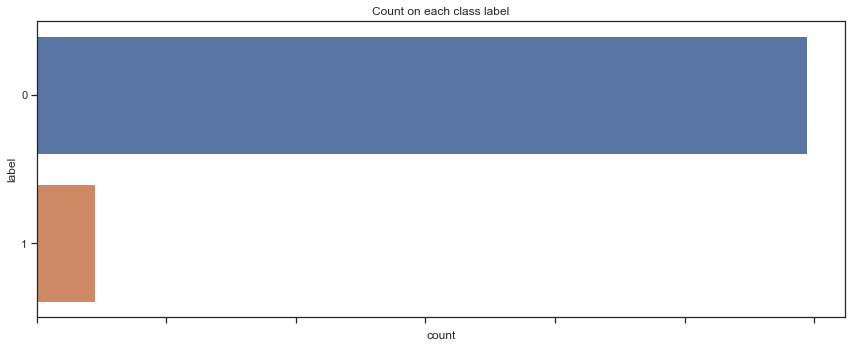

In [36]:
# Check for Class imbalances
plt.figure(figsize=(12,5))
sns.set(rc={'figure.figsize':(50, 15)}, style='ticks')
g = sns.countplot(y=df["label"])
g.set_xticklabels(g.get_xticklabels(), rotation=90, ha="right")
plt.title('Count on each class label')
plt.tight_layout()
plt.show()

In [37]:
df["label"].value_counts()

0    29720
1     2242
Name: label, dtype: int64

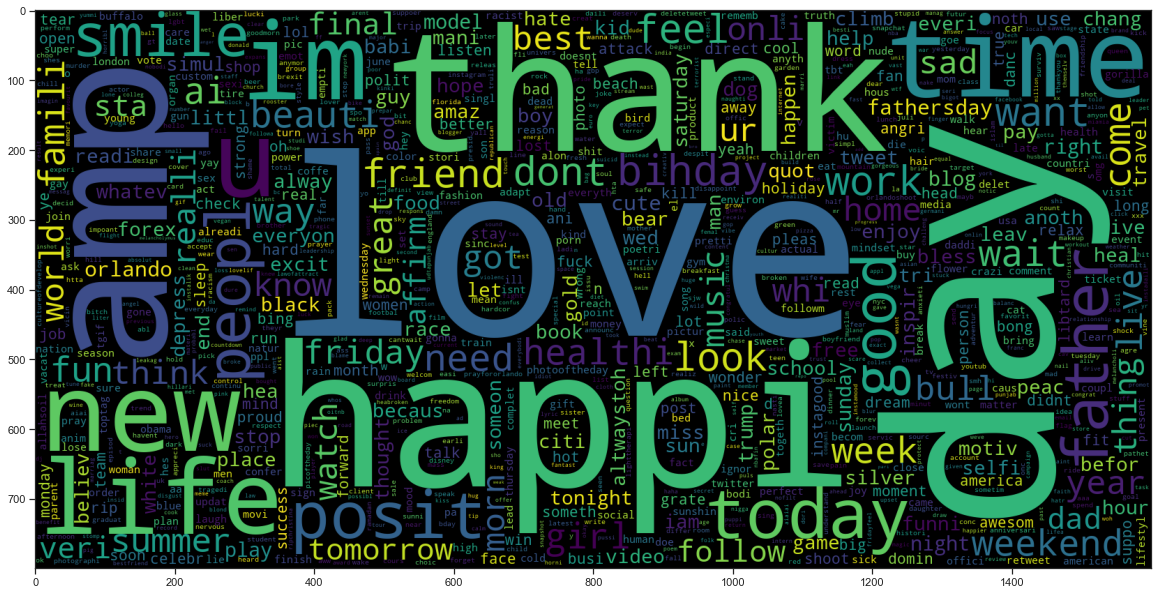

In [38]:
#Word Cloud for whole speeches
X = df["tweet"]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(X))
plt.imshow(wc)

In [39]:
y = df["label"]

In [40]:
# defining parameter range 
param_grid = {'C': [0.1, 1, 10, 100],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'gamma':['scale', 'auto'],
              'kernel': ['linear']}  
pipeline = Pipeline([('Vect',TfidfVectorizer()),
                  ('model',GridSearchCV(SVC(probability=True), param_grid, refit = True, verbose = 3,n_jobs=-1))])

In [41]:
skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=1)
lst_accu_stratified = []
  
for train_index, test_index in skf.split(X, y):
    x_train_fold, x_test_fold = X[train_index], X[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]
    pipeline.fit(x_train_fold, y_train_fold)
    lst_accu_stratified.append(pipeline.score(x_test_fold, y_test_fold))


Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits


In [54]:
print('List of possible accuracy:', lst_accu_stratified)
print('\nMaximum Accuracy That can be obtained from this model is:',
      max(lst_accu_stratified)*100, '%')
print('\nMinimum Accuracy:',
      min(lst_accu_stratified)*100, '%')
print('\nOverall Accuracy:',
      mean(lst_accu_stratified)*100, '%')
print('\nStandard Deviation is:', stdev(lst_accu_stratified))

List of possible accuracy: [0.9540704586696702, 0.9593267004567925]

Maximum Accuracy That can be obtained from this model is: 95.93267004567925 %

Minimum Accuracy: 95.40704586696702 %

Overall Accuracy: 95.66985795632313 %

Standard Deviation is: 0.003716724211230241


In [ ]:
grid_predictions = pipeline.predict(x_test_fold) 
   
# print classification report 
print(classification_report(y_test_fold, grid_predictions)) 

In [ ]:
import pickle

# save
with open('model.pkl','wb') as f:
    pickle.dump(pipeline,f)

In [3]:
#test data
test_data = pd.read_csv("test.csv")

In [4]:
test_data.head()

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."


In [5]:
test_data.drop("id",axis=1,inplace=True)
test_data.head()

,tweet
0,#studiolife #aislife #requires #passion #dedic...
1,@user #white #supremacists want everyone to s...
2,safe ways to heal your #acne!! #altwaystohe...
3,is the hp and the cursed child book up for res...
4,"3rd #bihday to my amazing, hilarious #nephew..."


In [6]:
#Normalize Diacritics
def simplify(text):
    '''Function to handle the diacritics in the text'''
    import unicodedata
    try:
        text = unicode(text, 'utf-8')
    except NameError:
        pass
    text = unicodedata.normalize('NFD', text).encode('ascii', 'ignore').decode("utf-8")
    return str(text)

In [15]:
test_data["tweet"] = test_data["tweet"].apply(simplify)

In [16]:
def filter_text(text):
    text = re.sub(r'@\w+', '',text)
    text = re.sub(r'http\S+', '', text)
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = [stemmer.stem(word) for word in text.split(' ')]
    text=" ".join(text)
    # Remove stopwords
    text = remove_stopwords(text)
 
    return text

In [17]:
test_data["tweet"] = test_data["tweet"].apply(filter_text)

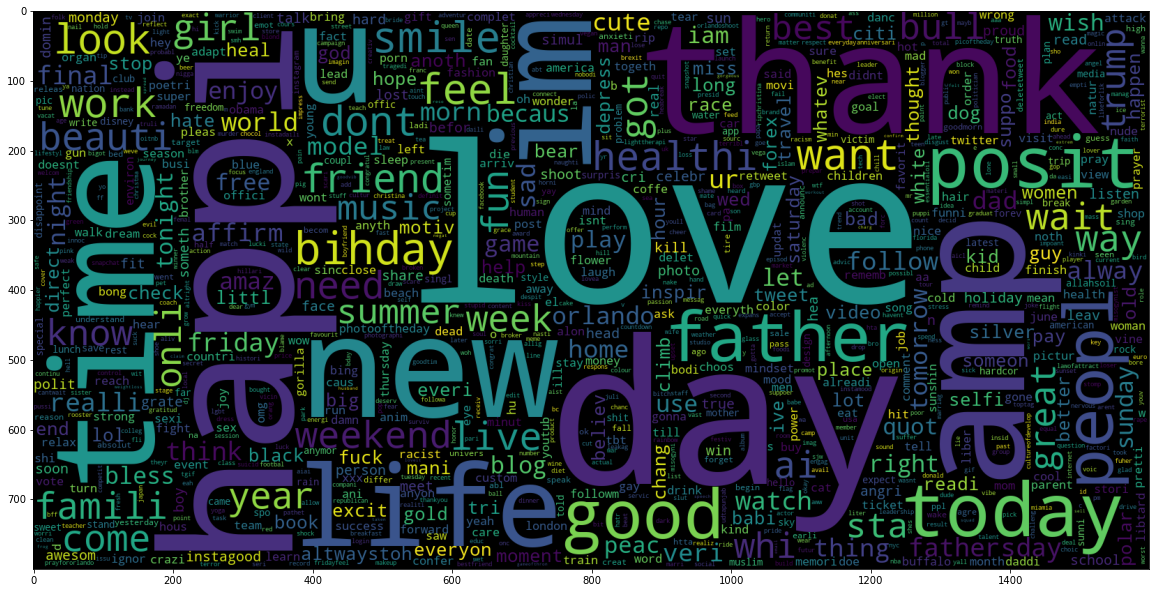

In [18]:
#Word Cloud for whole speeches
test_data = test_data["tweet"]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(test_data))
plt.imshow(wc)

In [20]:
# load
import pickle
with open('model.pkl', 'rb') as f:
    model = pickle.load(f)

In [21]:
pred = model.predict(test_data)

In [30]:
pred[:30]

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])

In [27]:
predic_proba = model.predict_proba(test_data)

In [28]:
predic_proba[:30]

array([[9.67918491e-01, 3.20815090e-02],
       [2.18299922e-01, 7.81700078e-01],
       [9.91279218e-01, 8.72078235e-03],
       [9.82790674e-01, 1.72093260e-02],
       [9.97509478e-01, 2.49052172e-03],
       [9.78254923e-01, 2.17450774e-02],
       [9.93392122e-01, 6.60787790e-03],
       [9.76740477e-01, 2.32595230e-02],
       [9.94328701e-01, 5.67129891e-03],
       [9.66732506e-01, 3.32674944e-02],
       [9.47867745e-01, 5.21322554e-02],
       [9.70645639e-01, 2.93543609e-02],
       [9.96484945e-01, 3.51505508e-03],
       [9.90202534e-01, 9.79746626e-03],
       [9.39760936e-01, 6.02390641e-02],
       [8.07791909e-01, 1.92208091e-01],
       [9.94998002e-01, 5.00199756e-03],
       [9.43615228e-01, 5.63847717e-02],
       [9.52977001e-01, 4.70229987e-02],
       [4.71884230e-03, 9.95281158e-01],
       [9.98390651e-01, 1.60934861e-03],
       [9.93254997e-01, 6.74500328e-03],
       [9.96414922e-01, 3.58507763e-03],
       [9.94354773e-01, 5.64522671e-03],
       [9.790904